In [1]:
import numpy as np
import pickle
import tqdm

def burgers(y, u, delta_x, nu=0.01):
    """
    Return the change rate of state vector, given the current state y and control signal u, following 1D Burgers' equation.

    :param y: (n,), state vector.
    :param u: (m,), control signal.
    :param delta_x: a small spatial length, used as dx in the numerical solution of differential equation.
    :param nu: Kinematic viscosity.

    :return: (n,), change rate of state vector
    """
    assert type(y) == np.ndarray and type(u) == np.ndarray, "y and u must be numpy arrays"
    assert y.ndim == 1 and u.ndim == 1, "y and u must be 1 dimensional arrays"
    assert y.shape == u.shape, "y and u must have the same shape"
    
    y_b = np.roll(y, -1)
    y_b[-1] = y[-1]
    y_a = np.roll(y, 1)
    y_a[0] = y[0]
    dydt = -y * (y_b - y_a) / (2 * delta_x) + nu * (y_b - 2 * y + y_a) / delta_x**2
    return dydt + u  # Adding control influence to the state evolution

def generate_initial_u(x):
    """
    Generate the initial state u(0, x) as a superposition of two Gaussian functions.
    """
    # Sampling parameters for the Gaussian functions
    a1 = np.random.uniform(0, 2)
    a2 = np.random.uniform(-2, 0)
    b1 = np.random.uniform(0.2, 0.4)
    b2 = np.random.uniform(0.6, 0.8)
    sigma1 = np.random.uniform(0.05, 0.15)
    sigma2 = np.random.uniform(0.05, 0.15)
    
    u = a1 * np.exp(-((x - b1)**2) / (2 * sigma1**2)) + a2 * np.exp(-((x - b2)**2) / (2 * sigma2**2))
    u[0] = 0
    u[-1] = 0
    return u

def generate_control_sequence(x, t):
    """
    Generate control sequence w(t, x) as a superposition of 8 Gaussian functions.
    """
    w = np.zeros_like(x)
    for i in range(8):
        ind = np.random.binomial(1, 0.5)
        if i==0:
            ai = np.random.uniform(-1.5,1.5)
        else:
            if ind:
                ai = np.random.uniform(-1.5,1.5)
            else:
                ai = 0
        b1_i = np.random.uniform(0, 1)
        b2_i = np.random.uniform(0, 1)
        sigma1_i = np.random.uniform(0.05, 0.2)
        sigma2_i = np.random.uniform(0.05, 0.2)
        
        w += ai * np.exp(-((x - b1_i)**2) / (2 * sigma1_i**2)) * np.exp(-((t - b2_i)**2) / (2 * sigma2_i**2))
    
    return w

if __name__ == '__main__':
    # Set general parameters
    n = 128 # Number of spatial nodes (grid points)
    T = 8 # Number of time steps stored (from 10000 time steps, we store only 10)
    T_sim = 800
    N = 100 # Number of samples (trajectories)
    nu=0.01  # Kinematic viscosity

    # Spatial grid from 0 to 1, discretized into n points
    x_range=(-5,5)
    x = np.linspace(*x_range, n)
    dx=(x_range[1]-x_range[0])/n
    
    Y_bar = []  # Holds states from y_0 to y_{T-1}
    Y_f = []    # Holds final state y_T
    U = []      # Holds control sequence u_0 to u_{T-1}
    
    # Simulate the system for N samples
    for _ in tqdm.tqdm(range(N)):
        # Sample initial state u(0, x)
        u = generate_initial_u(x)
        
        # Sample control sequence w(t, x) at 10 time steps
        w = []
        for t_idx in range(T):
            t = t_idx * 0.1  # Time stamps are from 0.0 to 0.9 in steps of 0.1
            w_t = generate_control_sequence(x, t)
            w.append(w_t)
        
        # Initialize lists to store the state trajectory
        y = [u]  # Starting state
        
        # Generate the state trajectory using the Burger equation
        delta_t = 1  # Time step size for sampling
        delta_t_sim = T_sim / T  # Time step size for simulation
        for t_idx in range(1, T):
            u_prev = y[-1]  # Previous state is the last element in the list
            u_current = burgers(u_prev, w[t_idx-1], delta_x=dx, nu=nu)
            y.append(u_current)
            # print(u_current.max())
        
        # Store the data
        Y_bar.append(np.stack(y[:-1]))  # Y_bar contains states from y_0 to y_{T-1}
        Y_f.append(y[-1])               # Y_f contains the final state y_T
        U.append(np.stack(w[:-1]))           # U contains control sequence w_0 to w_{T-1}
    
    # Save the generated data into a dictionary
    data_name = f'burger_{n}_{n}_{T-1}_{N}_{delta_t}.pkl'
    data_dict = {}
    data_dict['sys'] = {"C": np.identity(n)}  # Assuming the system matrix C is identity
    data_dict['meta_data'] = {
        'num_nodes': n, 
        'input_dim': n, 
        'control_horizon': T - 1, 
        'num_samples': N
    }
    
    # Store the generated data
    data_dict['data'] = {'Y_bar': np.array(Y_bar), 'Y_f': np.array(Y_f), 'U': np.flip(np.array(U), axis=1)}

100%|██████████| 100/100 [00:00<00:00, 581.09it/s]


In [2]:
print(data_dict['data']['Y_bar'].shape)
print(data_dict['data']['Y_f'].shape)
print(data_dict['data']['U'].shape)

(100, 7, 128)
(100, 128)
(100, 7, 128)


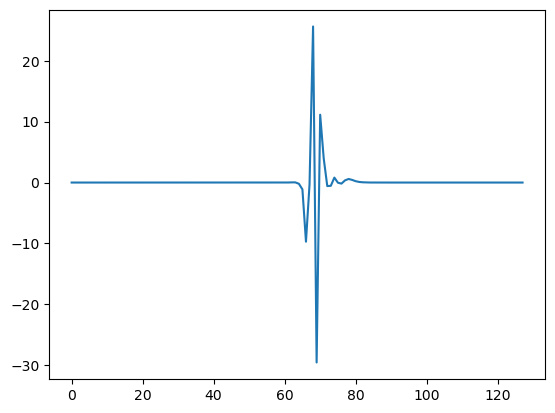

In [10]:
import matplotlib.pyplot as plt
plt.plot(data_dict['data']['Y_bar'][0][2])